In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data._main import *
from omegaconf import OmegaConf
from testing.leandro.plots import *
from testing.leandro.filters import *
from testing.leandro.metrics import *

In [3]:
config = OmegaConf.load("/home/lrvnc/projects/worm-graph/conf/dataset.yaml")
print("\nconfig:\n\t", OmegaConf.to_yaml(config), end="\n\n")
dataset = get_dataset(config)


config:
	 dataset:
  name:
  - Kato2015


Chosen dataset(s): ['Kato2015']
Num. worms: 12



In [4]:
oneWorm = dataset['worm0']

In [5]:
display_neurons = np.random.choice(np.where(oneWorm['named_neurons_mask']==True)[0], 5).tolist()

# Plot Functions
---

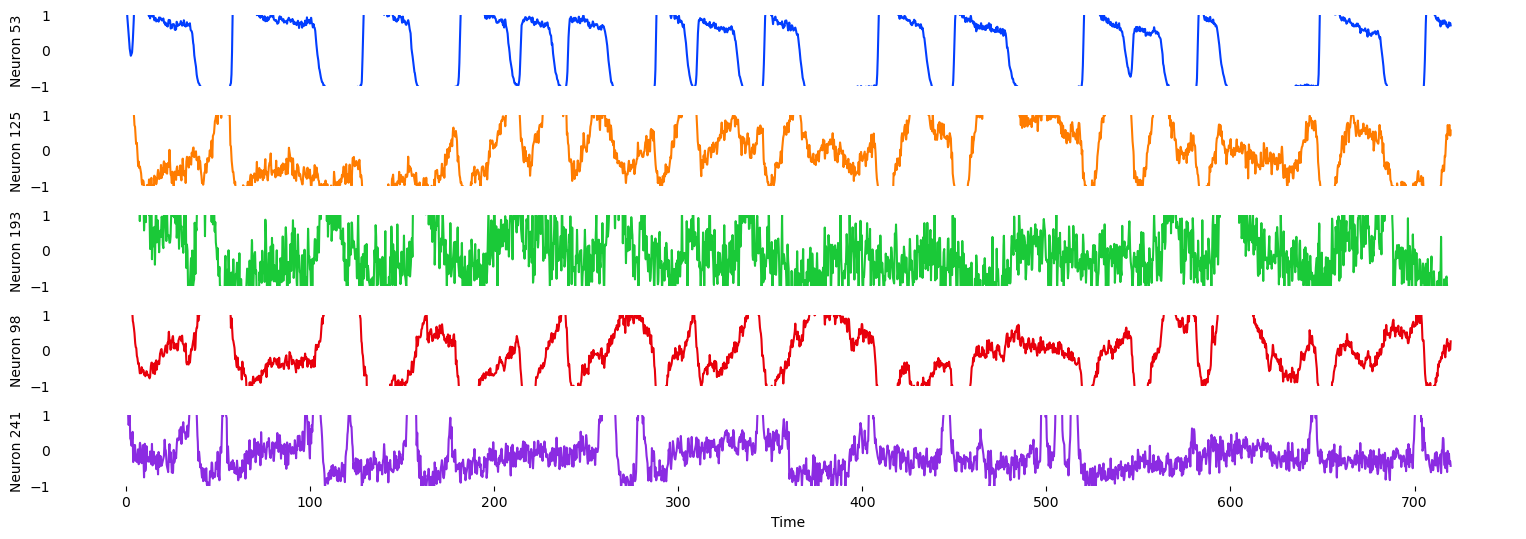

In [6]:
plot_signals(oneWorm['calcium_data'], oneWorm['time_in_seconds'], display_neurons)

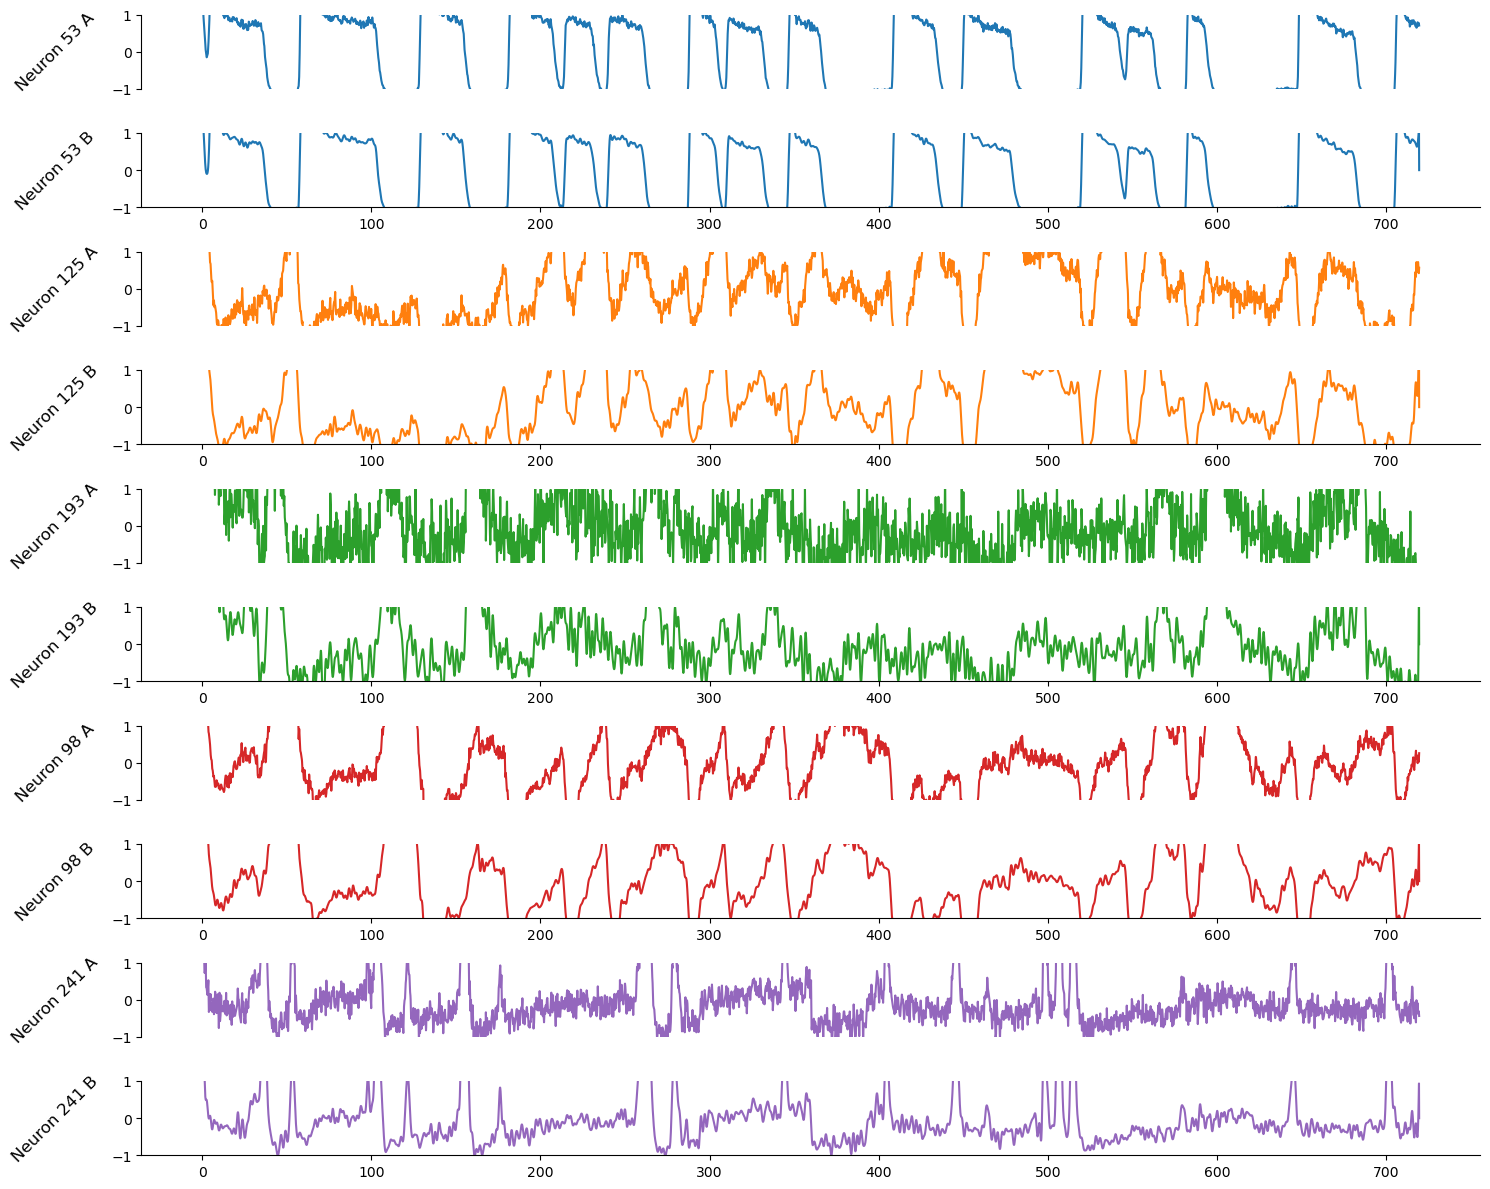

In [7]:
compare_signals(oneWorm['calcium_data'], oneWorm['smooth_calcium_data'], oneWorm['time_in_seconds'], display_neurons)

# Gaussian noise?
---

In [8]:
rep = 100
noise_level = np.zeros((rep, 302)) # rep x neurons

for r in range(rep):
    gaussian_noise = np.random.normal(0, 1, oneWorm['calcium_data'].shape)
    noise_level[r,:] = cosine_similarity(oneWorm['calcium_data'], gaussian_noise)

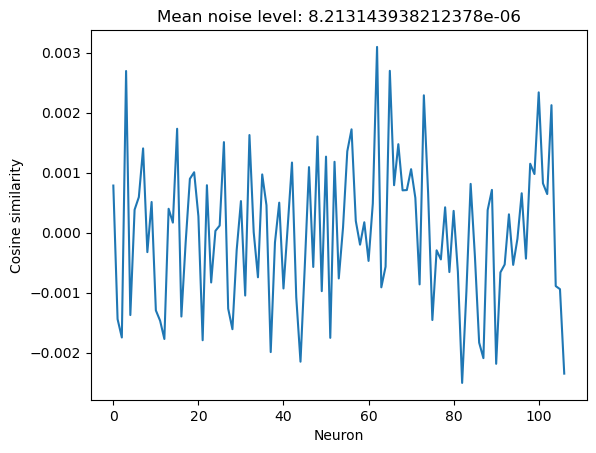

In [9]:
neuron_noise_level = np.mean(noise_level, axis=0)
active_neurons = np.where(neuron_noise_level != 0)[0]
plt.plot(neuron_noise_level[active_neurons])
mean = np.mean(neuron_noise_level[active_neurons])
plt.title('Mean noise level: {}'.format(mean))
plt.xlabel('Neuron')
plt.ylabel('Cosine similarity')
plt.show()

# Moving Average
---

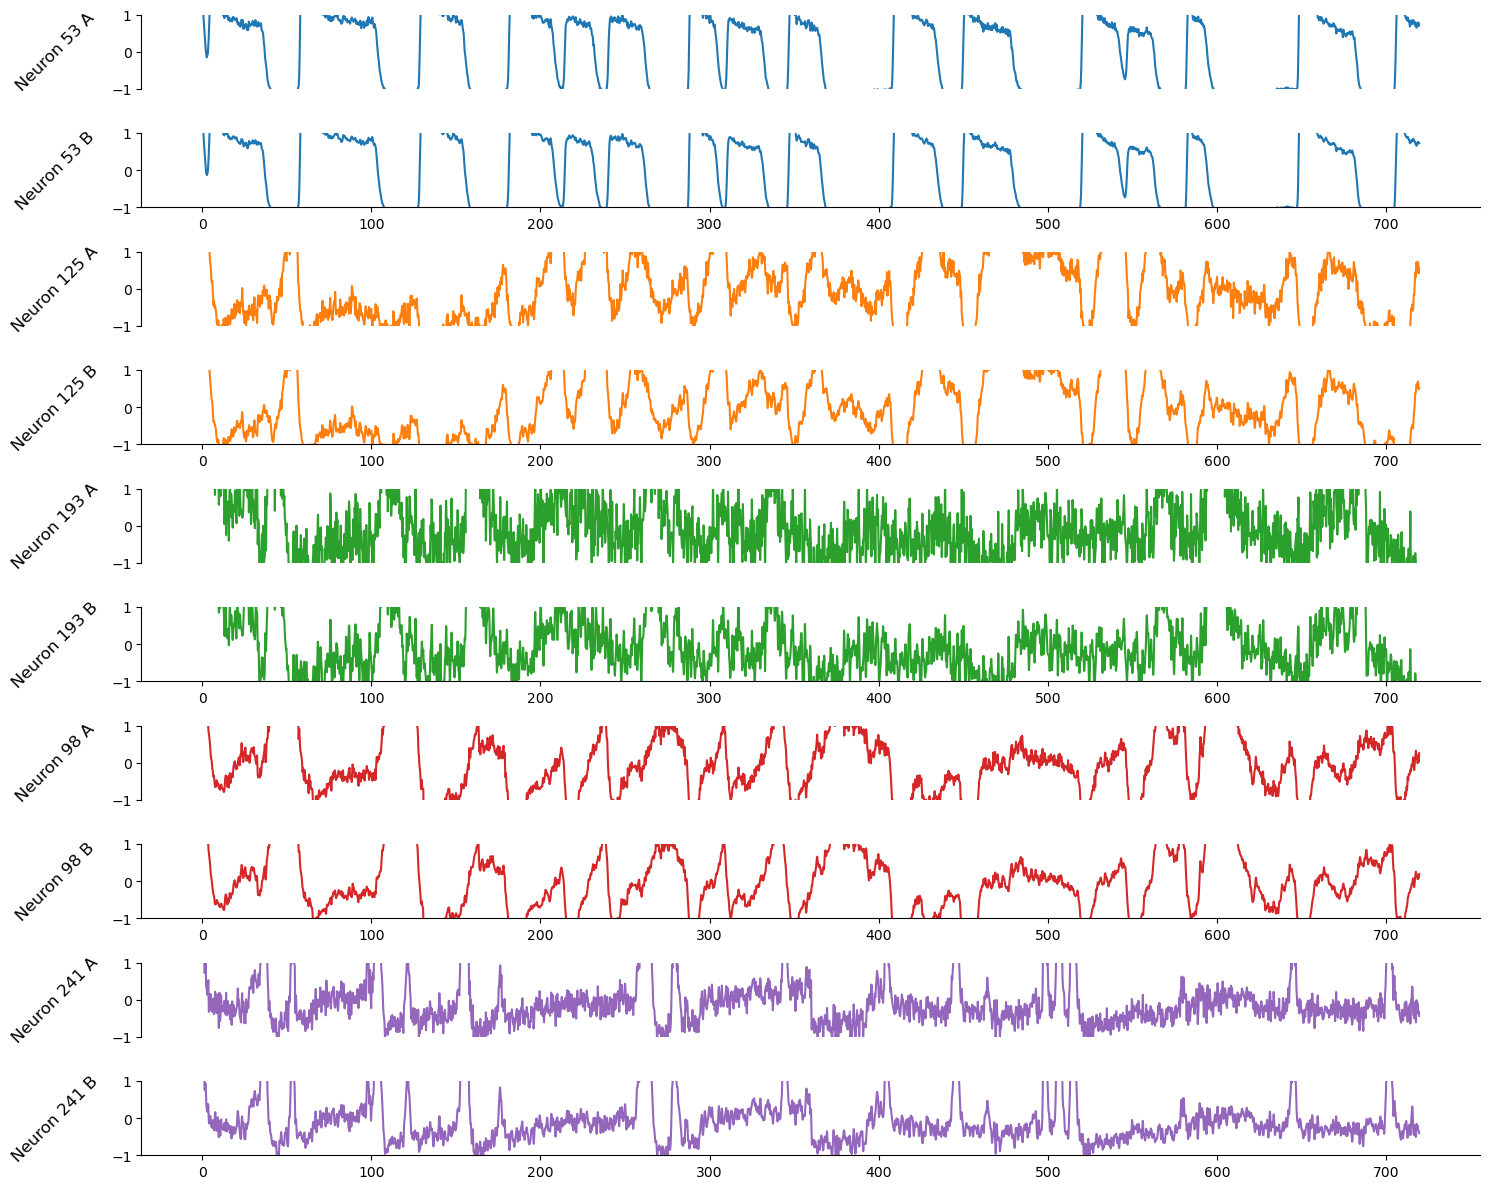

In [10]:
mvAvg = moving_average_filter(oneWorm['calcium_data'], 5)
compare_signals(oneWorm['calcium_data'], mvAvg, oneWorm['time_in_seconds'], display_neurons)

# Gaussian Average
---

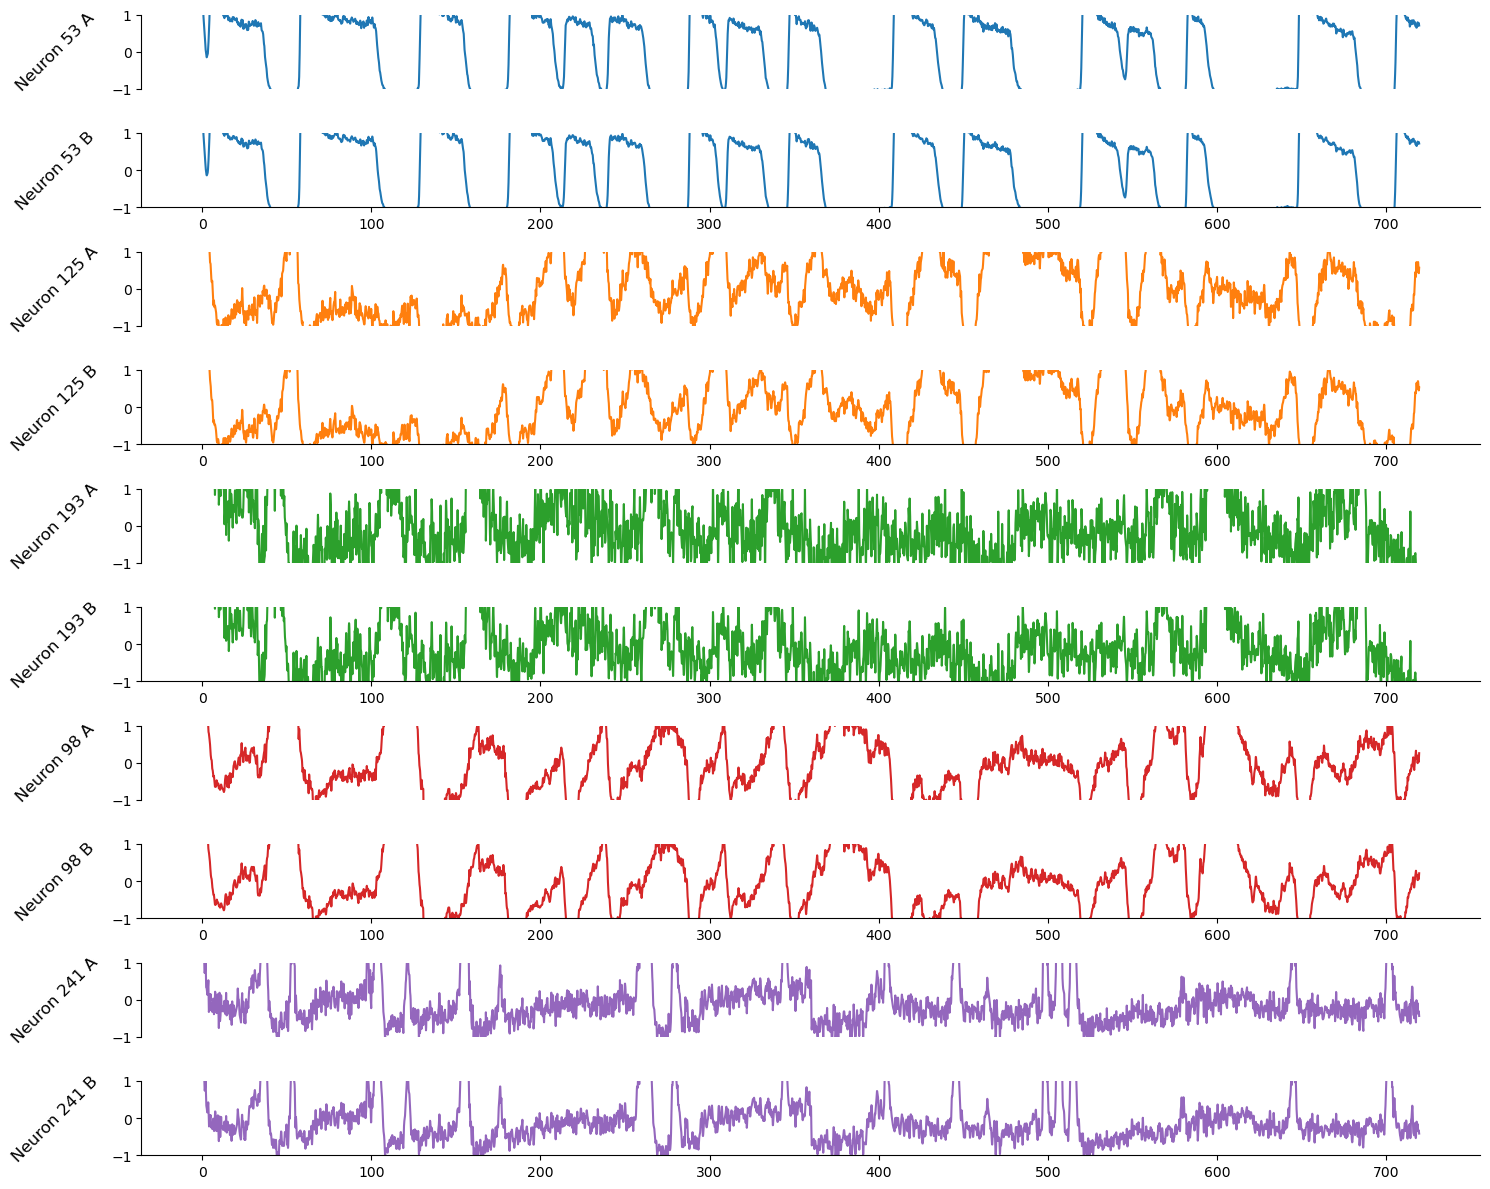

In [11]:
gAvg = gaussian_average_filter(oneWorm['calcium_data'], 1)
compare_signals(oneWorm['calcium_data'], gAvg, oneWorm['time_in_seconds'], display_neurons)

# Median Filter
---

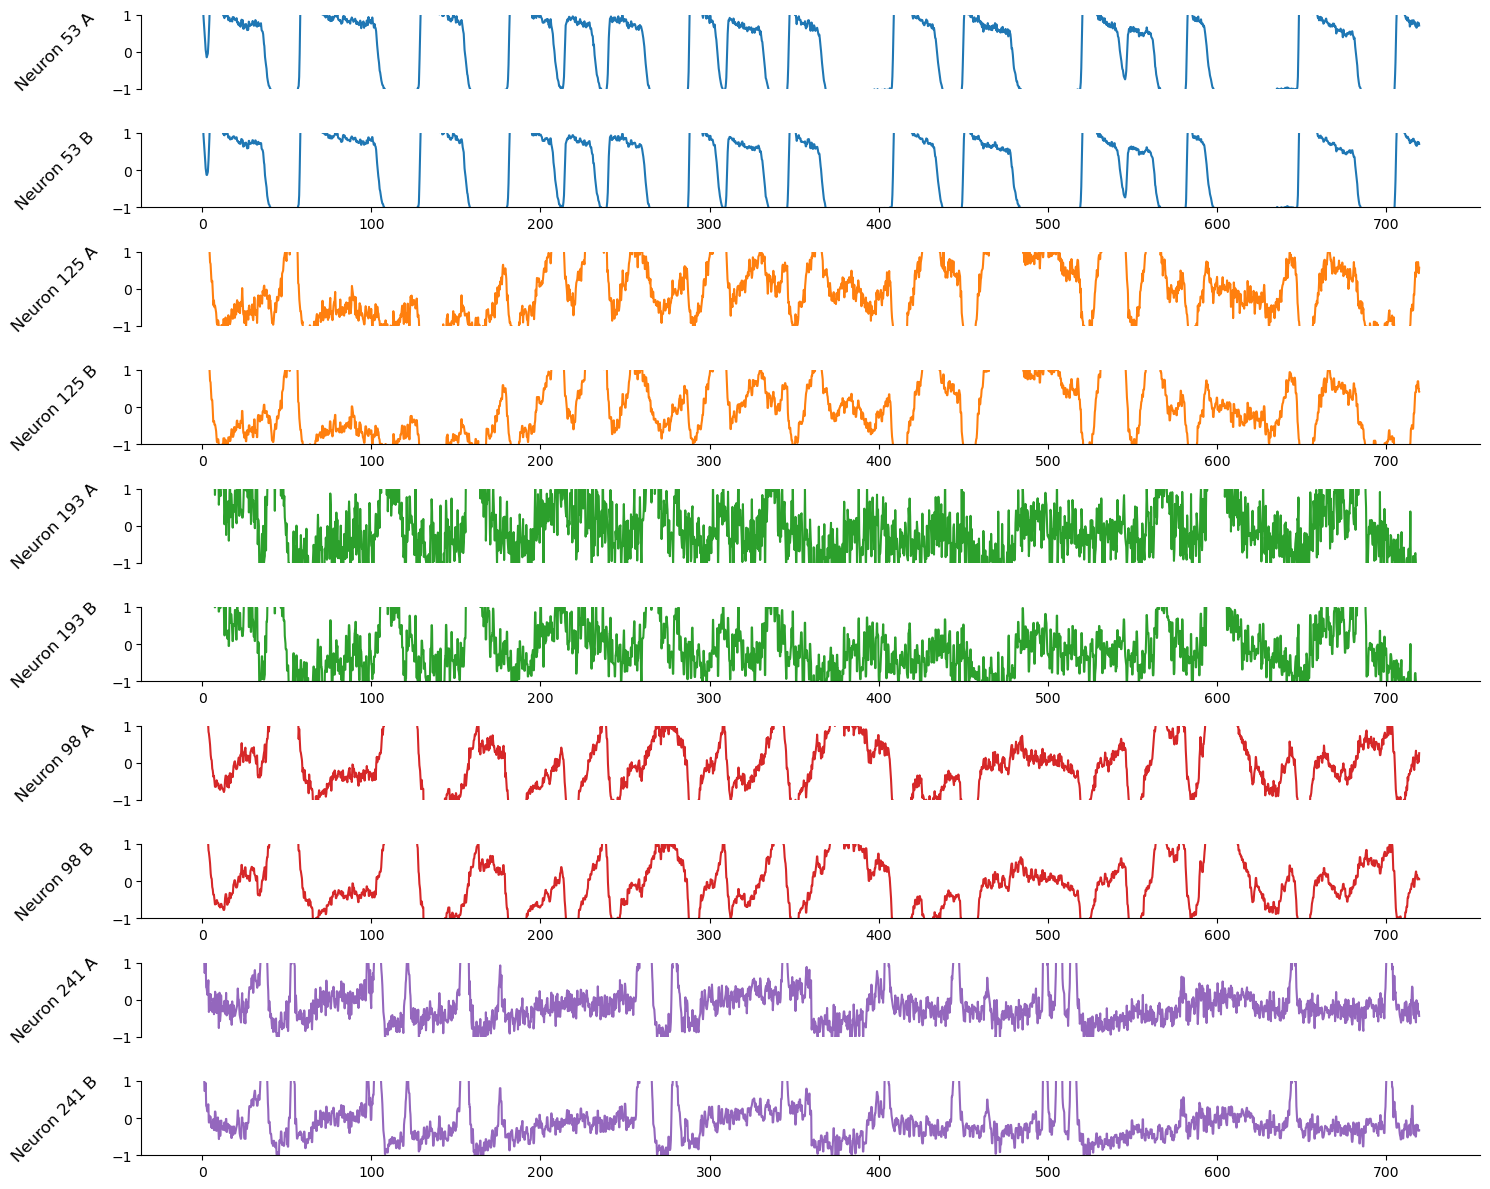

In [12]:
mFilter = median_filter(oneWorm['calcium_data'], 5)
compare_signals(oneWorm['calcium_data'], mFilter, oneWorm['time_in_seconds'], display_neurons)

# SG Filter
---

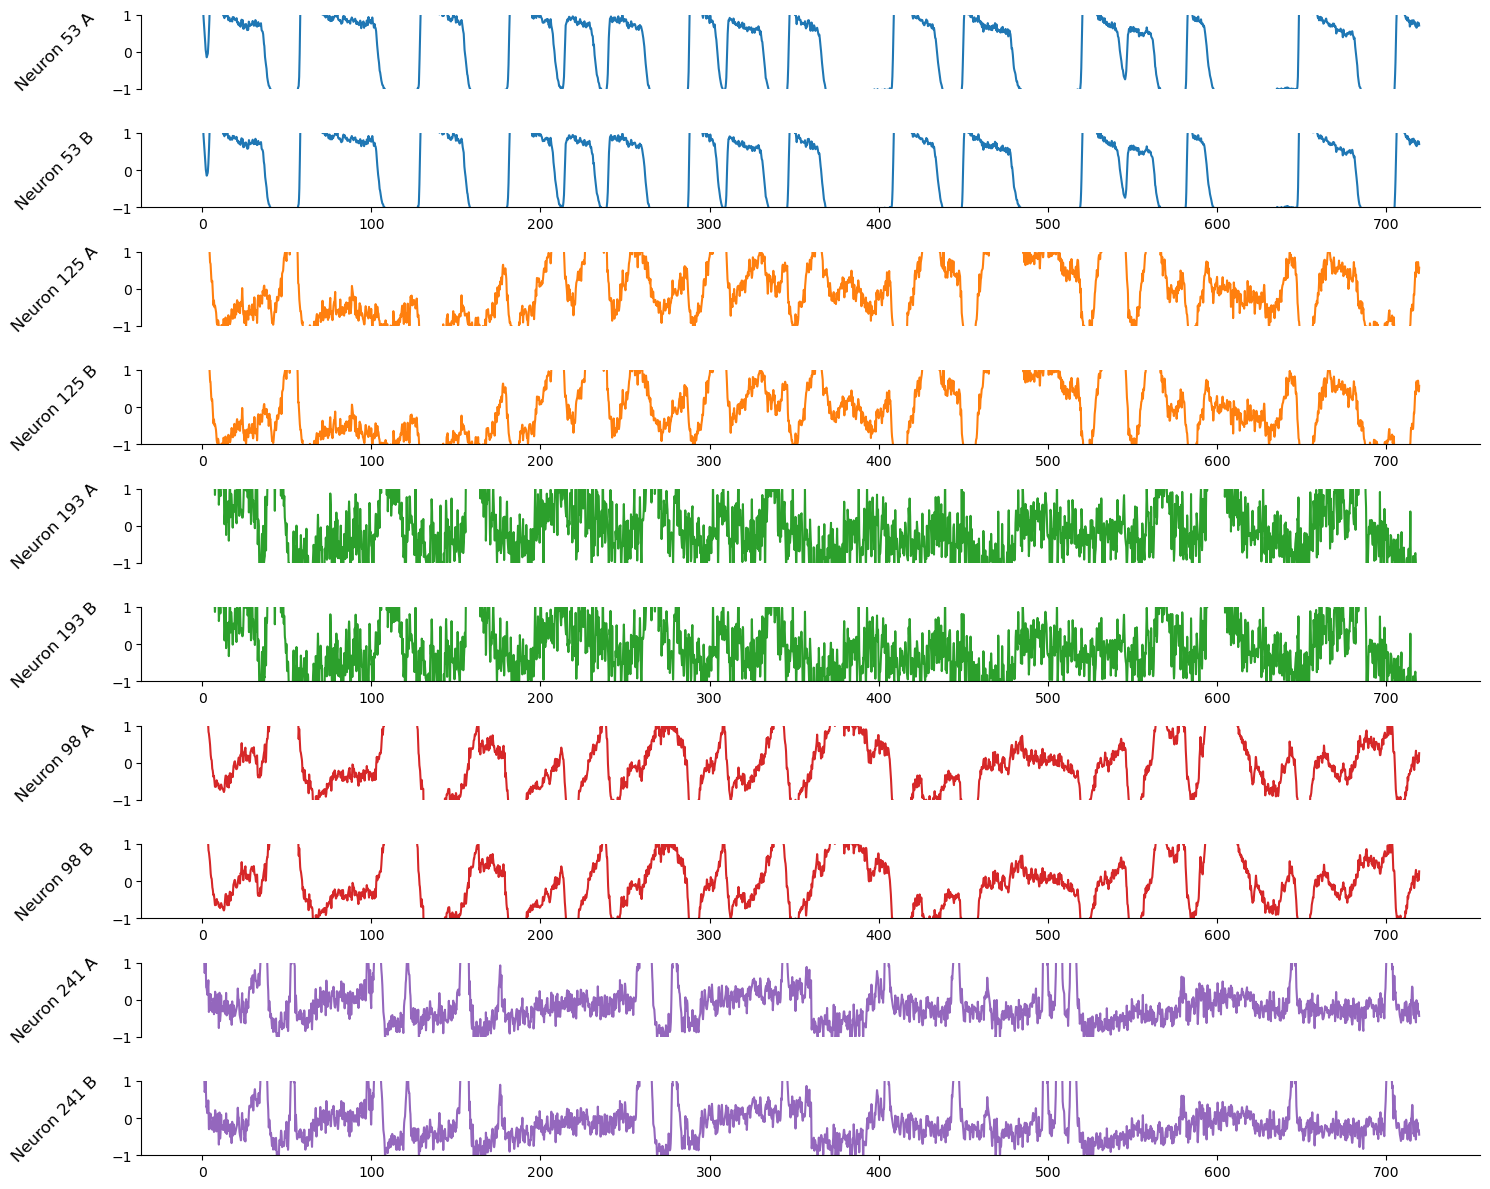

In [13]:
sgFilter = savitzky_golay_filter(oneWorm['calcium_data'], 5, 2)
compare_signals(oneWorm['calcium_data'], sgFilter, oneWorm['time_in_seconds'], display_neurons)

# FFT
---

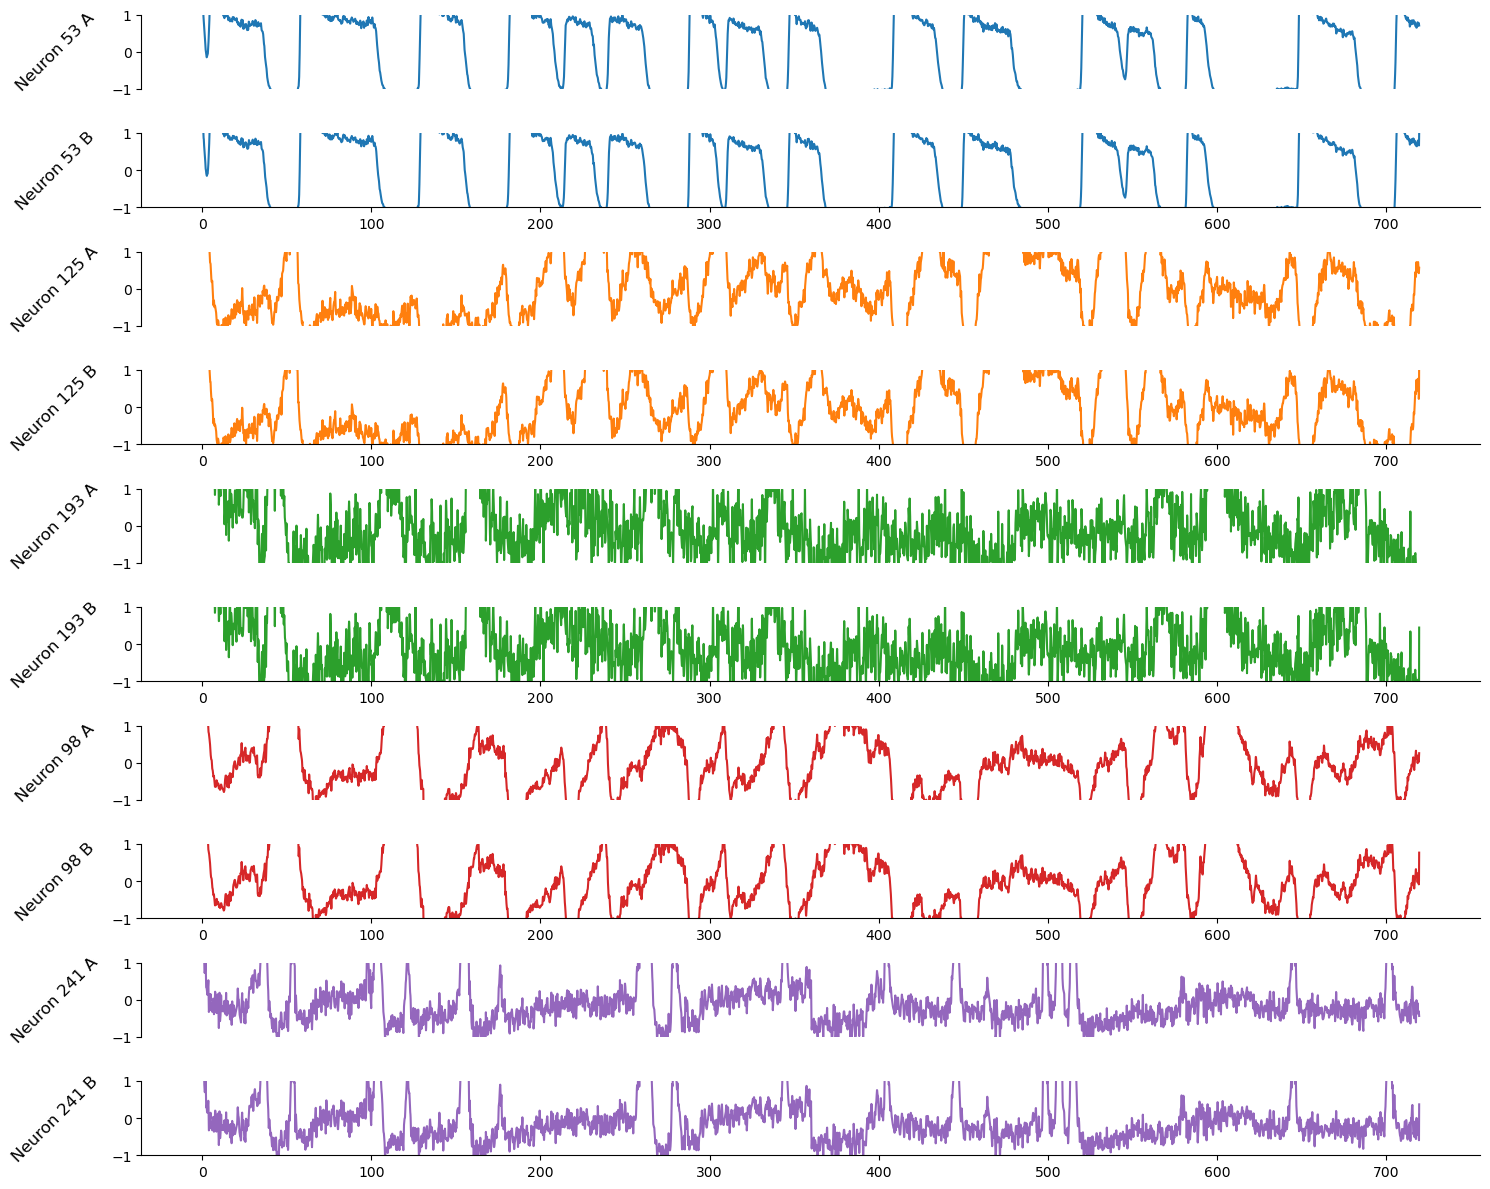

In [32]:
fft_data = frequency_filter(oneWorm['calcium_data'], float(oneWorm['dt'][0][0]), 0.5)
compare_signals(oneWorm['calcium_data'], fft_data, oneWorm['time_in_seconds'], display_neurons)

# Temporal Filter + Remove Artifacts
---

(6883, 302)


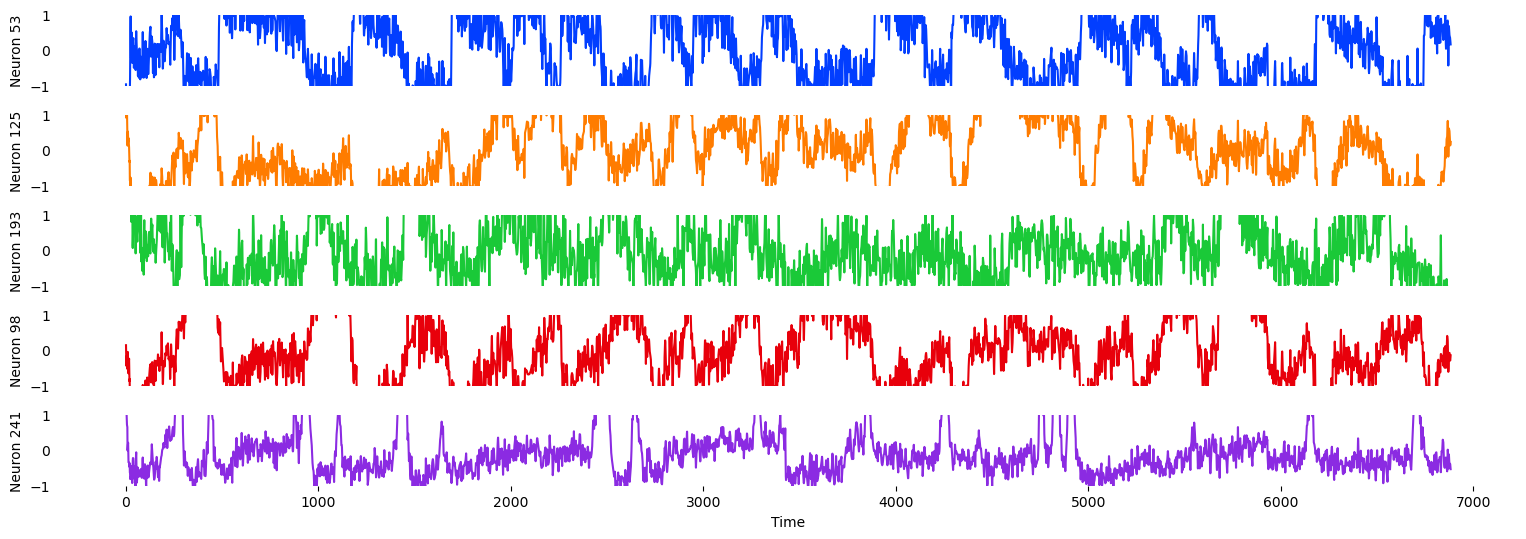

In [33]:
temp_filt_data = temporal_filter(signal=oneWorm['calcium_data'], cutoff_frequency=0.01, fs=10).copy()
temp_filt_data = remove_artifacts(data=temp_filt_data, threshold=2)
print(temp_filt_data.shape) 
plot_signals(torch.from_numpy(temp_filt_data), torch.from_numpy(np.arange(temp_filt_data.shape[0])), display_neurons)

#compare_signals(oneWorm['calcium_data'], temp_filt_data, oneWorm['time_in_seconds'], display_neurons)

The problem with this method is that it throws up some data points...

# Compare methods
---

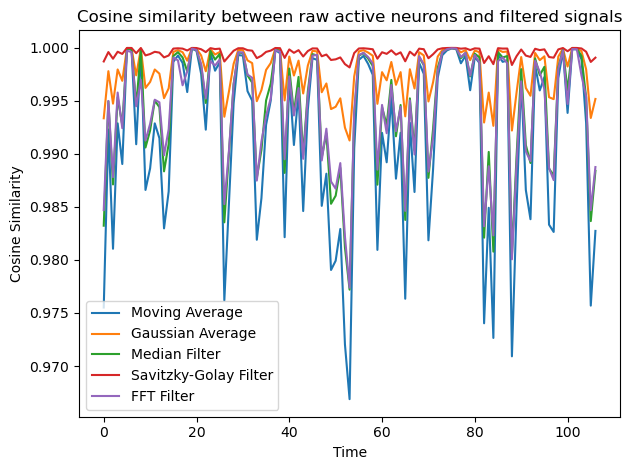

In [34]:
active_neurons = oneWorm['calcium_data'][:,oneWorm['neurons_mask']]

mvAvg = moving_average_filter(oneWorm['calcium_data'], window_size=5)
gAvg = gaussian_average_filter(oneWorm['calcium_data'], sigma=1)
mFilter = median_filter(oneWorm['calcium_data'], window_size=5)
sgFilter = savitzky_golay_filter(oneWorm['calcium_data'], window_size=5, poly_order=2)
fft_data = frequency_filter(oneWorm['calcium_data'], float(oneWorm['dt'][0][0]), percentage=0.7)

sim_mvAvg = cosine_similarity(active_neurons, mvAvg[:,oneWorm['neurons_mask']])
sim_gAvg = cosine_similarity(active_neurons, gAvg[:,oneWorm['neurons_mask']])
sim_mFilter = cosine_similarity(active_neurons, mFilter[:,oneWorm['neurons_mask']])
sim_sgFilter = cosine_similarity(active_neurons, sgFilter[:,oneWorm['neurons_mask']])
sim_fft = cosine_similarity(active_neurons, fft_data[:,oneWorm['neurons_mask']])

plt.plot(sim_mvAvg, label='Moving Average')
plt.plot(sim_gAvg, label='Gaussian Average')
plt.plot(sim_mFilter, label='Median Filter')
plt.plot(sim_sgFilter, label='Savitzky-Golay Filter')
plt.plot(sim_fft, label='FFT Filter')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cosine Similarity')
plt.title('Cosine similarity between raw active neurons and filtered signals')
plt.tight_layout()
plt.show()